In [16]:
# load the package
include("../FractionalFlow/FractionalFlow.jl")
using PyPlot, SetPyPlot, NLopt, Dierckx, BlackBoxOptim, Statistics
import Calculus
import GR
FF = FractionalFlow

Main.FractionalFlow

## Note
For the tertiary low salinity water flooding, the recovery factor is calculated by 
$$R_{tert}=\frac{S_{w,avg}-(1-S_{or,hs})}{S_{or,hs}}$$
However, the recovery factor is usually reported as the percentage of the initial oil that is in the reservoir before the secondary formation water water flooding, i.e.,
$$R=\frac{S_{w,avg}-S_{w,init}}{1-S_{w,init}}$$
To convert one to the other, we can write
$$R=\frac{\left(R_{tert}S_{or,hs}+(1-S_{or,hs})\right)-S_{w,init}}{1-S_{w,init}}$$
We can also do it the other way around, i.e.,
$$R_{tert}=\frac{R\left(1-S_{w,init}\right)+S_{w,init}-\left(1-S_{or,hs}\right)}{S_{or,hs}}$$

# Tertiary Water-flooding

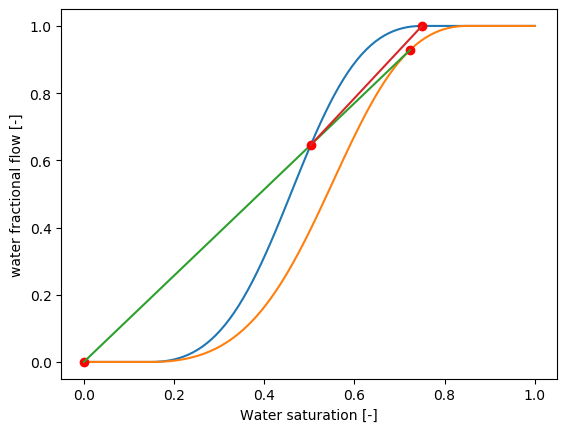

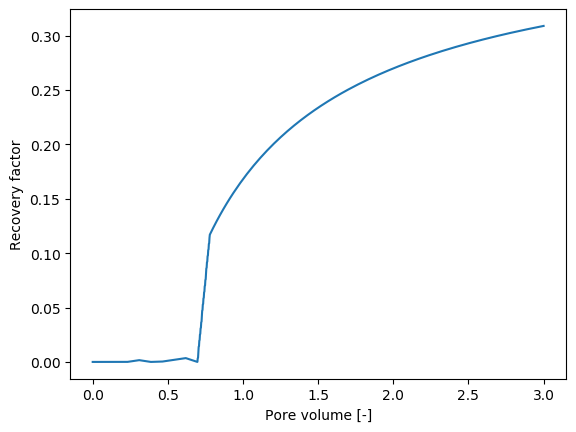

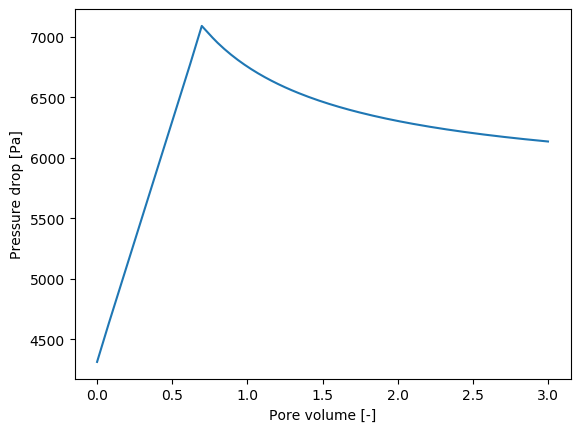

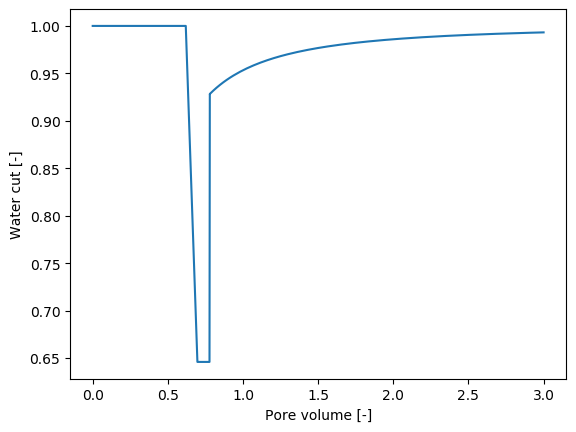

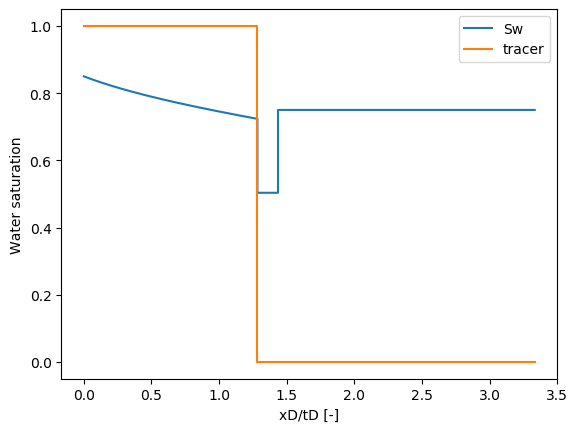

PyObject <matplotlib.legend.Legend object at 0x0000000037723E10>

In [17]:
# define the problem
sw0 = 0.15 # initial condition of the experiment
sor_hs = 0.25 # high salinity (formation water) residual oil saturation
sw_init = 1-sor_hs
fluids_hs = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
fluids_ls = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
rel_perms_hs = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
        swc=0.15, sor=sor_hs, nw=2.0, no = 2.0)
rel_perms_ls = FF.oil_water_rel_perms(krw0=0.3, kro0=0.95, 
        swc=0.15, sor=0.15, nw=2.0, no = 2.0)
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=3.0, p_back=1e5, sw_init=sw_init, 
    sw_inj=1.0, rel_perms=rel_perms_hs)
core_props = FF.core_properties()
wf_res = FF.low_sal_water_flood(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood)
FF.visualize(wf_res)

# synthetic experimental data
Here I scale the calculated recovery data to the total recovery data for a core initially saturated with oil at a saturation close to the connate water saturation, and secondary flooded with formation water.

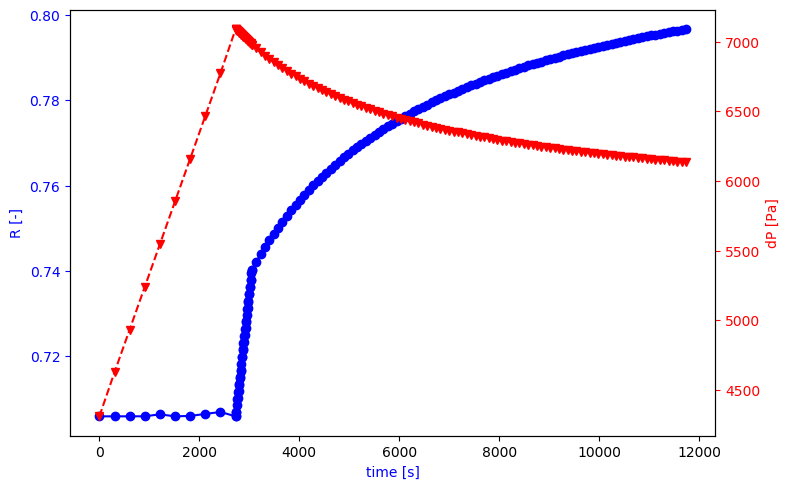

(Figure(PyObject <Figure size 800x500 with 2 Axes>), PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x00000000379386A0>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x000000004429DE48>)

In [18]:
R_exp = (wf_res.recovery_time[:,2].*sor_hs.+(1-sor_hs).-sw0)./(1.0-sw0)
t_exp_dp = wf_res.dp_time[:,1]
dp_exp = wf_res.dp_time[:,2]
t_exp_R = wf_res.recovery_time[:,1]
# R_exp = wf_res.recovery_time[:,2]
plotyy(t_exp_R, R_exp, t_exp_dp, dp_exp, fig_size = [8,5], x_label="time [s]", y1_label="R [-]", y2_label="dP [Pa]")

Later, we need to convert the above data back to the tertiary recovery factor, as if the core flooding experiments starts with a core saturated with $S_{or,hs}$ oil saturation.

# define the objective function

In [19]:
# struct
struct exp_data
    t_exp_dp
    dp_exp
    t_exp_R
    R_exp
end

# convert the recovery data
R_conv = (R_exp.*(1-sw0).+sw0.-(1-sor_hs))/sor_hs
exp_data1 = exp_data(t_exp_dp, dp_exp, t_exp_R, R_conv);

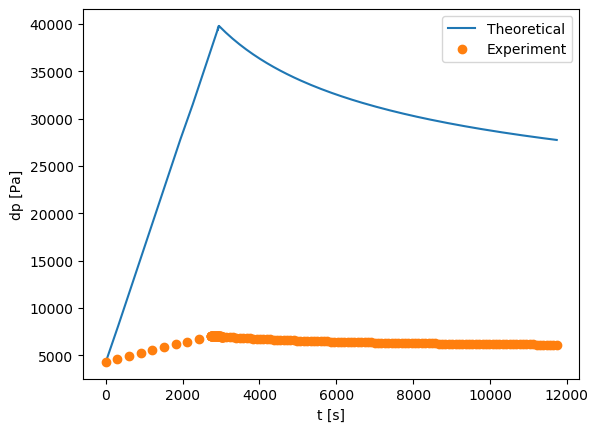

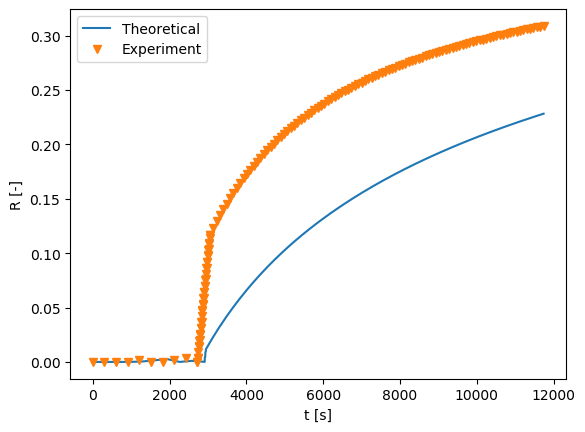

4.074281143472932

In [20]:
"""
rel_perm_param [krw0, kro0, nw, no, swc, sor]
core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood
"""
function error_calc(rel_perm_param, exp_data, core_props, fluids_ls, fluids_hs, 
        rel_perms_hs, core_flood; w_p=1.0, w_R=1.0)
    rel_perms_ls = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
    wf_res = FF.low_sal_water_flood(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood)
    dp_calc = Spline1D(wf_res.dp_time[:,1], wf_res.dp_time[:,2], k=1, bc="nearest")
    R_calc = Spline1D(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], k=1, bc="nearest")
    error_dp = abs.(dp_calc(exp_data.t_exp_dp) .- exp_data.dp_exp)
#     println(error_dp)
    error_R = abs.(R_calc(exp_data.t_exp_R) .- exp_data.R_exp)
#     println(error_R)
    error_dp_norm = w_p.*error_dp./exp_data.dp_exp
    error_R_norm = w_R.*error_R #./(exp_data.R_exp+eps()) # to avoid division by a small number
    return mean(error_R_norm)+mean(error_dp_norm)
end

function vis_error(rel_perm_param, exp_data, core_props, fluids_ls, fluids_hs, 
        rel_perms_hs, core_flood)
    rel_perms_ls = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
    wf_res = FF.low_sal_water_flood(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood)
    figure()
    plot(wf_res.dp_time[:,1], wf_res.dp_time[:,2],  exp_data.t_exp_dp, exp_data.dp_exp, "o")
    xlabel("t [s]")
    ylabel("dp [Pa]")
    legend(["Theoretical", "Experiment"])
    
    figure()
    plot(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], exp_data.t_exp_R, exp_data.R_exp, "v")
    xlabel("t [s]")
    ylabel("R [-]")
    legend(["Theoretical", "Experiment"])
    
end

# test
x_init = [0.109681, 0.201297, 3.96653, 3.0, 0.19, 0.1]

vis_error(x_init, exp_data1, core_props, fluids_ls, fluids_hs, rel_perms_hs, core_flood)
error_calc(x_init, exp_data1, core_props, fluids_ls, fluids_hs, rel_perms_hs, core_flood)

# define the objective function and gradients and weight factors

In [11]:
# weight factors:
w_p = ones(length(exp_data1.dp_exp))
ind_max = indmax(exp_data1.dp_exp)
w_p[ind_max-1:ind_max+2] = 10
w_p[end:end-5]=10
w_p[1]=10
w_R = ones(length(exp_data1.R_exp))
w_R[20:25] = 10
w_R[end:end-5]=10


function f(x)
    f_val = 0.0
    try
        f_val = error_calc(x, exp_data1, core_props, fluids_ls, fluids_hs, 
            rel_perms_hs, core_flood, w_p = w_p, w_R = w_R)
    catch
        f_val = 100.0
#         info("Objective function did not converge!")
    end
    return f_val
end

    
function g(x)
    eps1 = 1e-4
    f_val = f(x)
    g_val = ones(length(x))
    try
        # g_val = Calculus.gradient(x -> error_calc(x, exp_data1, core_props, fluids, core_flood), x)
        for j in eachindex(x)
            x2 = copy(x)
            x2[j]+=eps1
            f_val2 = f(x2)
            g_val[j] = (f_val2-f_val)/eps1
        end
    catch
        g_val = ones(length(x))
    end
    return g_val
end

function obj_fun(param, grad)
    if length(grad)>0
      grad[:] = g(param)
    end
    
    obj_fun_val = f(param)
    if isnan(obj_fun_val) || isinf(obj_fun_val)
        obj_fun_val = 100.0
    end
    return obj_fun_val
end

# test
grad_x = zeros(6)
obj_fun([1.0, 0.8, 3, 4, 0.1, 0.1], grad_x)

f([1.0, 0.8, 2, 2, 0.1, 0.1])

INFO: This function does not work on this problem. Calling the single_ion_adsorption_water_flood_single_shock function ...
INFO: This function does not work on this problem. Calling the single_ion_adsorption_water_flood_single_shock function ...
INFO: This function does not work on this problem. Calling the single_ion_adsorption_water_flood_single_shock function ...
INFO: This function does not work on this problem. Calling the single_ion_adsorption_water_flood_single_shock function ...
INFO: This function does not work on this problem. Calling the single_ion_adsorption_water_flood_single_shock function ...
INFO: Cross point is estimated: 0.7494494494494494, error is 0.00020259657634746908
INFO: This function does not work on this problem. Calling the single_ion_adsorption_water_flood_single_shock function ...
INFO: This function does not work on this problem. Calling the single_ion_adsorption_water_flood_single_shock function ...


0.7874113732597706

INFO: This function does not work on this problem. Calling the single_ion_adsorption_water_flood_single_shock function ...
INFO: This function does not work on this problem. Calling the single_ion_adsorption_water_flood_single_shock function ...


In [12]:
grad_x

6-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [11]:
## algorithms
# L: Local, G:global
# D: derivative-based, N: non-derivative (search-based)

# :LD_MMA
# :LN_COBYLA
# :LD_LBFGS
# :GN_DIRECT
# :GN_DIRECT_L
# GN_CRS2_LM
# G_MLSL_LDS
# GD_STOGO
# GN_ISRES
# GN_ESCH
# LN_NEWUOA_BOUND
# LN_BOBYQA
# LN_PRAXIS
# LN_NELDERMEAD
# LN_SBPLX
# LD_SLSQP
# LD_TNEWTON_PRECOND_RESTART
# LD_TNEWTON_RESTART
# LD_TNEWTON_PRECOND


In [15]:
x_init = [0.5, 0.8, 2.5, 2.5, 0.15, 0.15]
x_lb = [0.1, 0.1, 1.5, 1.5, 0.05, 0.1]
x_ub = [1.0, 1.0, 4.0, 4.0, core_flood.initial_water_saturation, 0.25]
opt_alg=:LN_COBYLA
opt1 = Opt(opt_alg, length(x_init)) # choose the algorithm
lower_bounds!(opt1, x_lb)
upper_bounds!(opt1, x_ub)
ftol_rel!(opt1, 1e-15)
ftol_abs!(opt1, 1e-15)

min_objective!(opt1, obj_fun)
(fObjOpt, paramOpt, flag) = optimize(opt1, x_init)

INFO: This function does not work on this problem. Calling the single_ion_adsorption_water_flood_single_shock function ...
INFO: This function does not work on this problem. Calling the single_ion_adsorption_water_flood_single_shock function ...
INFO: This function does not work on this problem. Calling the single_ion_adsorption_water_flood_single_shock function ...
INFO: This function does not work on this problem. Calling the single_ion_adsorption_water_flood_single_shock function ...
INFO: Cross point is estimated: 0.6142642642642642, error is 0.021356920744849406
INFO: This function does not work on this problem. Calling the single_ion_adsorption_water_flood_single_shock function ...
INFO: Cross point is estimated: 0.6142642642642642, error is 0.021356920744849406
INFO: This function does not work on this problem. Calling the single_ion_adsorption_water_flood_single_shock function ...
INFO: This function does not work on this problem. Calling the single_ion_adsorption_water_flood_s

(0.037519143204668995, [0.308955, 0.690188, 2.12074, 2.10107, 0.259621, 0.148149], :FTOL_REACHED)

INFO: This function does not work on this problem. Calling the single_ion_adsorption_water_flood_single_shock function ...
INFO: Cross point is estimated: 0.6915659493472859, error is 0.002118296376964701


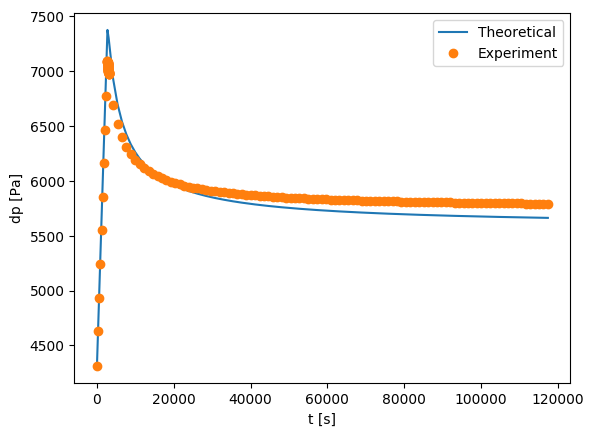

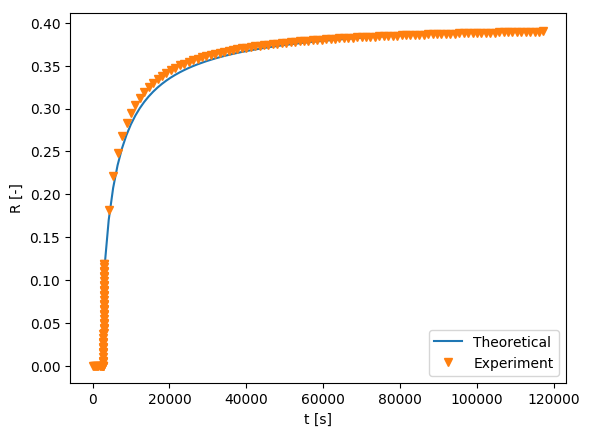

0.027467894766478568

In [16]:
x_init = paramOpt
vis_error(x_init, exp_data1, core_props, fluids_ls, fluids_hs, rel_perms_hs, core_flood)
error_calc(x_init, exp_data1, core_props, fluids_ls, fluids_hs, rel_perms_hs, core_flood)

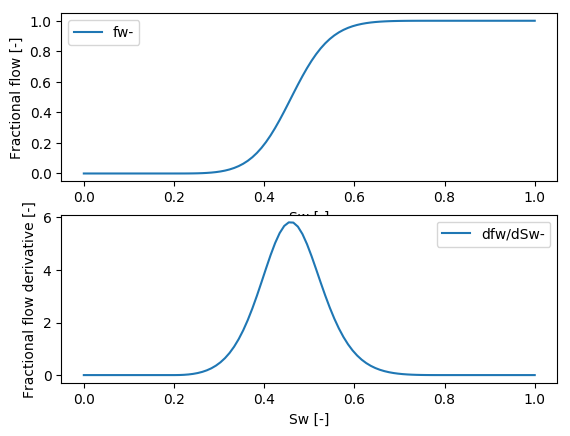

PyObject <matplotlib.legend.Legend object at 0x7f15558edb50>

In [38]:
rel_perm_param=[1.0, 0.8, 3, 4, 0.2, 0.2]
rel_perms2 = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
FF.visualize(rel_perms2, fluids)